<a href="https://colab.research.google.com/github/estherkxy/GA_Projects/blob/main/Capstone/code/5_Bert_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT - Train

Notebook 5/6

In [1]:
!pip install transformers

import transformers
import torch
import tensorflow as tf

from sklearn import metrics
from sklearn.model_selection import KFold


import numpy as np
import pandas as pd
import time
import datetime
import random
import io
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

print('Transformers version: ', transformers.__version__)
print('Tensorflow version: ', tf.__version__)

     |████████████████████████████████| 3.5 MB 5.4 MB/s 
     |████████████████████████████████| 895 kB 33.8 MB/s 
     |████████████████████████████████| 6.8 MB 30.1 MB/s 
     |████████████████████████████████| 596 kB 45.8 MB/s 
     |████████████████████████████████| 67 kB 5.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Transformers version:  4.16.2
Tensorflow version:  2.8.0


In [2]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Loading datasets
# from google.colab import drive
# drive.mount('/content/drive')

tw = pd.read_csv('./drive/My Drive/GA/capstone/data/tweets_train.csv', encoding = 'latin-1')
train_df = pd.read_csv('./drive/My Drive/GA/capstone/data/train_tweets_clean.csv')
test_df = pd.read_csv('./drive/My Drive/GA/capstone/data/tweets_test_text.csv')
results = pd.read_csv('./drive/My Drive/GA/capstone/data/tweets_testblank.csv')

# BERT Tokenization & Preparation

### Parsing

Let's extract the sentences and labels of our training set as numpy ndarrays.

In [5]:
# Get the lists of sentences and their labels.
sentences = train_df.text.values
labels = train_df.sentiment.values

### Importing BertTokenizer

In [6]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

n=55
# Print the original sentence.
print(' Original: ', train_df['text'][n])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(train_df['text'][n]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(train_df['text'][n])))

Loading BERT tokenizer...


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

 Original:  why does apple force people to use its vpn built in to ios off button doesn't work ffs like i want apple's nsa data collection service
Tokenized:  ['why', 'does', 'apple', 'force', 'people', 'to', 'use', 'its', 'vp', '##n', 'built', 'in', 'to', 'ios', 'off', 'button', 'doesn', "'", 't', 'work', 'ff', '##s', 'like', 'i', 'want', 'apple', "'", 's', 'nsa', 'data', 'collection', 'service']
Token IDs:  [2339, 2515, 6207, 2486, 2111, 2000, 2224, 2049, 21210, 2078, 2328, 1999, 2000, 16380, 2125, 6462, 2987, 1005, 1056, 2147, 21461, 2015, 2066, 1045, 2215, 6207, 1005, 1055, 23971, 2951, 3074, 2326]


The transformers library provides a helpful `encode` function which will handle most of the parsing and data prep steps for us.

Before we are ready to encode our text, though, we need to decide on a **maximum sentence length** for padding / truncating to.

The below cell will perform one tokenization pass of the dataset in order to measure the maximum sentence length.

In [7]:
train_df.loc[55]['text']

"why does apple force people to use its vpn built in to ios off button doesn't work ffs like i want apple's nsa data collection service"

In [8]:
train_df.text = [tokenizer.tokenize(x) for x in train_df.text]
train_df.shape

(3142, 4)

In [9]:
train_df.head()

,Unnamed: 0,sentiment,date,text
0,0,0,mon dec 01 19:30:03 +0000 2014,"[aa, ##pl, ##the, best, steve, jobs, emails, e..."
1,1,0,mon dec 01 19:43:51 +0000 2014,"[rt, jp, ##des, ##log, ##es, why, aa, ##pl, st..."
2,2,0,mon dec 01 19:50:28 +0000 2014,"[my, cat, only, chew, ##s, apple, cords, such,..."
3,3,0,mon dec 01 20:26:34 +0000 2014,"[i, agree, with, jim, ##cr, ##ame, ##r, that, ..."
4,4,0,mon dec 01 20:29:33 +0000 2014,"[nobody, expects, the, spanish, inquisition, a..."


In [10]:
pd.set_option('display.max_colwidth', -1)
train_df['length'] = [len(x) for x in train_df.text]
#train_df = train_df[train_df['length']<=50] #to drop the three unrelated tweets, possibly from weather stations.
train_df.reset_index(drop=True,inplace=True)
train_df.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


(3142, 5)

In [11]:
train_df.head()

,Unnamed: 0,sentiment,date,text,length
0,0,0,mon dec 01 19:30:03 +0000 2014,"[aa, ##pl, ##the, best, steve, jobs, emails, ever]",8
1,1,0,mon dec 01 19:43:51 +0000 2014,"[rt, jp, ##des, ##log, ##es, why, aa, ##pl, stock, had, a, mini, -, flash, crash, today, $, aa, ##pl, aa, ##pl]",21
2,2,0,mon dec 01 19:50:28 +0000 2014,"[my, cat, only, chew, ##s, apple, cords, such, an, apples, ##nob]",11
3,3,0,mon dec 01 20:26:34 +0000 2014,"[i, agree, with, jim, ##cr, ##ame, ##r, that, the, individual, ##in, ##ves, ##tor, should, own, not, trade, apple, aa, ##pl, it, ', s, extended, so, today, ', s, pull, ##back, is, good, to, see]",34
4,4,0,mon dec 01 20:29:33 +0000 2014,"[nobody, expects, the, spanish, inquisition, aa, ##pl]",7


### Tokenize Dataset

In [12]:
max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  44


Just in case there are some longer test sentences, I'll set the maximum length to 64.

Now we're ready to perform the real tokenization.

The `tokenizer.encode_plus` function combines multiple steps for us:

1. Split the sentence into tokens.
2. Add the special `[CLS]` and `[SEP]` tokens.
3. Map the tokens to their IDs.
4. Pad or truncate all sentences to the same length.
5. Create the attention masks which explicitly differentiate real tokens from `[PAD]` tokens.

The first four features are in `tokenizer.encode`, but I'm using `tokenizer.encode_plus` to get the fifth item (attention masks). Documentation is [here](https://huggingface.co/transformers/main_classes/tokenizer.html?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus).

In [13]:
# Tokenize all of the sentences and map the tokens to their word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  ['aa', '##pl', '##the', 'best', 'steve', 'jobs', 'emails', 'ever']
Token IDs: tensor([  101,  9779, 24759, 10760,  2190,  3889,  5841, 22028,  2412,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


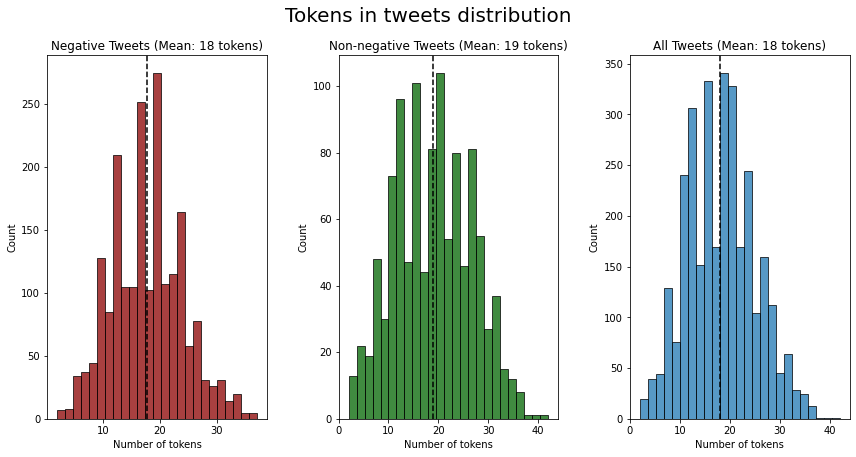

In [14]:
# Plotting the distribution of number of tokens
fig, ax = plt.subplots(1, 3, figsize=(12,6), sharey=False)
ax = ax.ravel()

neg_df = train_df[train_df['sentiment'] == 0]
#neu_df = train_df[train_df['sentiment'] == 0]
nonneg_df = train_df[train_df['sentiment'] == 1]

# Plot negative tweets df   
g1 = sns.histplot(data=neg_df, x=neg_df['text'].str.len(), ax = ax[0], 
                  bins=25, color='darkred')
mean_1 = neg_df['text'].str.len().mean()
ax[0].axvline(mean_1, ls='--', color='black')
g1.set_title(f'Negative Tweets (Mean: {round(mean_1)} tokens)')
g1.set_xlabel(f'Number of tokens')


# Plot non-negative tweets df
g2 = sns.histplot(data=nonneg_df, x=nonneg_df['text'].str.len(), 
                  ax = ax[1], bins=25, color='darkgreen')
mean_2 = nonneg_df['text'].str.len().mean()
ax[1].axvline(mean_2, ls='--', color='black')
g2.set_title(f'Non-negative Tweets (Mean: {round(mean_2)} tokens)')
g2.set_xlabel(f'Number of tokens')

# Plot overall tweets df
g3 = sns.histplot(data=train_df, x=train_df['text'].str.len(), ax = ax[2], bins=25)
mean_3 = train_df['text'].str.len().mean()
ax[2].axvline(mean_3, ls='--', color='black')
g3.set_title(f'All Tweets (Mean: {round(mean_3)} tokens)')
g3.set_xlabel(f'Number of tokens')

plt.suptitle('Tokens in tweets distribution', fontsize=20, x=0.5, y=1.05)
plt.tight_layout()

### Training & Validation Split

Divide up our training set to use 80% for training and 20% for validation.

In [15]:
# # splitting the data into X & y
# tweet = train_df.text.values
# labels = train_df.sentiment.values

In [16]:
# Use train_test_split to split our data into train and validation sets for
# training
from sklearn.model_selection import train_test_split

# Use 80% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.2)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=2018, test_size=0.2)

In [17]:
# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct 

In [18]:
# from torch.utils.data import TensorDataset, random_split
# from sklearn.model_selection import train_test_split

# # Combine the training inputs into a TensorDataset.
# dataset = TensorDataset(input_ids, attention_masks, labels)

# # Create a 80-20 train-validation split.

# # Calculate the number of samples to include in each set.
# train_size = int(0.8 * len(dataset))
# val_size = len(dataset) - train_size

# # Divide the dataset by randomly selecting samples.
# train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# print('{:>5,} training samples'.format(train_size))
# print('{:>5,} validation samples'.format(val_size))

We'll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [19]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [20]:
# from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# # The DataLoader needs to know our batch size for training, so we specify it 
# # here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# # size of 16 or 32.
# batch_size = 32

# # Create the DataLoaders for our training and validation sets.
# # We'll take training samples in random order. 
# train_dataloader = DataLoader(
#             train_dataset,  # The training samples.
#             sampler = RandomSampler(train_dataset), # Select batches randomly
#             batch_size = batch_size # Trains with this batch size.
#         )

# # For validation the order doesn't matter, so we'll just read them sequentially.
# validation_dataloader = DataLoader(
#             val_dataset, # The validation samples.
#             sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
#             batch_size = batch_size # Evaluate with this batch size.
#         )

# Loading BERT Classification Model

Now that our input data is properly formatted, it's time to fine tune the BERT model.

We'll be using [BertForSequenceClassification](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#bertforsequenceclassification). This is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier. As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task. 


Now to load BERT. There are a few different pre-trained BERT models available. "bert-base-uncased" means the version that has only lowercase letters ("uncased") and is the smaller version of the two ("base" vs "large").

The documentation for `from_pretrained` can be found [here](https://huggingface.co/transformers/v2.2.0/main_classes/model.html#transformers.PreTrainedModel.from_pretrained), with the additional parameters defined [here](https://huggingface.co/transformers/v2.2.0/main_classes/configuration.html#transformers.PretrainedConfig).

In [21]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()
#model.cpu()

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

We can browse all of the model's parameters by name here.

In the below cell, I've printed out the names and dimensions of the weights for:

- The embedding layer.
- The first of the twelve transformers.
- The output layer.

In [22]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

### Optimizer & Learning Rate Scheduler

Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend choosing from the following values (from Appendix A.3 of the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf)):

>- **Batch size:** 16, 32  
- **Learning rate (Adam):** 5e-5, 3e-5, 2e-5  
- **Number of epochs:** 2, 3, 4 

We chose:
* Batch size: 32 (set when creating our DataLoaders)
* Learning rate: 2e-5
* Epochs: 4 (we'll see that this is probably too many...)

The epsilon parameter `eps = 1e-8` is "a very small number to prevent any division by zero in the implementation" (from [here](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)).

You can find the creation of the AdamW optimizer in `run_glue.py` [here](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109).

In [23]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [24]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 3

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

### Training Loop

Below is our training loop. There's a lot going on, but fundamentally for each pass in our loop we have a training phase and a validation phase. 

> *Thank you to [Stas Bekman](https://ca.linkedin.com/in/stasbekman) for contributing the insights and code for using validation loss to detect over-fitting!*

**Training:**
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Clear out the gradients calculated in the previous pass. 
    - In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out.
- Forward pass (feed input data through the network)
- Backward pass (backpropagation)
- Tell the network to update parameters with optimizer.step()
- Track variables for monitoring progress

**Evalution:**
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Forward pass (feed input data through the network)
- Compute loss on our validation data and track variables for monitoring progress

Pytorch hides all of the detailed calculations from us, but we've commented the code to point out which of the above steps are happening on each line. 

> *PyTorch also has some [beginner tutorials](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) which you may also find helpful.*

Define a helper function for calculating accuracy.

In [25]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def conf_matrix(pred,labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return confusion_matrix(labels_flat,pred_flat)

Helper function for formatting elapsed times as `hh:mm:ss`

In [26]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [27]:
#!pip install pytorchtools
#from pytorchtools import EarlyStopping

In [28]:
import random


# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# initialize the early_stopping object
#early_stopping = EarlyStopping(patience=1, verbose=True)

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be misled--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 20 batches.
        if step % 20 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. The `forward` function is 
        # documented here: 
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = result.loss
        logits = result.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...
  Batch    20  of     79.    Elapsed: 0:00:14.
  Batch    40  of     79.    Elapsed: 0:00:27.
  Batch    60  of     79.    Elapsed: 0:00:41.

  Average training loss: 0.46
  Training epcoh took: 0:00:54

Running Validation...
  Accuracy: 0.85
  Validation Loss: 0.37
  Validation took: 0:00:05

======== Epoch 2 / 3 ========
Training...
  Batch    20  of     79.    Elapsed: 0:00:14.
  Batch    40  of     79.    Elapsed: 0:00:28.
  Batch    60  of     79.    Elapsed: 0:00:41.

  Average training loss: 0.31
  Training epcoh took: 0:00:54

Running Validation...
  Accuracy: 0.85
  Validation Loss: 0.35
  Validation took: 0:00:05

======== Epoch 3 / 3 ========
Training...
  Batch    20  of     79.    Elapsed: 0:00:14.
  Batch    40  of     79.    Elapsed: 0:00:27.
  Batch    60  of     79.    Elapsed: 0:00:41.

  Average training loss: 0.22
  Training epcoh took: 0:00:54

Running Validation...
  Accuracy: 0.87
  Validation Loss: 0.32
  Validation too

Viewing the summary of the training process.

In [29]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.46,0.37,0.85,0:00:54,0:00:05
2,0.31,0.35,0.85,0:00:54,0:00:05
3,0.22,0.32,0.87,0:00:54,0:00:05


In [45]:
# Exporting results
df_stats.to_csv('./drive/My Drive/GA/capstone/data/bert_train_results_df.csv')

From the table above, we can see that the training loss is going down with each epoch. However, on the other hand, the validation loss does not go down as much as the training loss and does increase at the 4th epoch. This may suggest that we are training our model for too many epochs, and it may be over-fitting on the training data.

Validation Loss is a more precise measure than accuracy, because with accuracy we don't care about the exact output value, but just which side of a threshold it falls on.

If we are predicting the correct answer, but with less confidence, then validation loss will catch this, while accuracy will not.

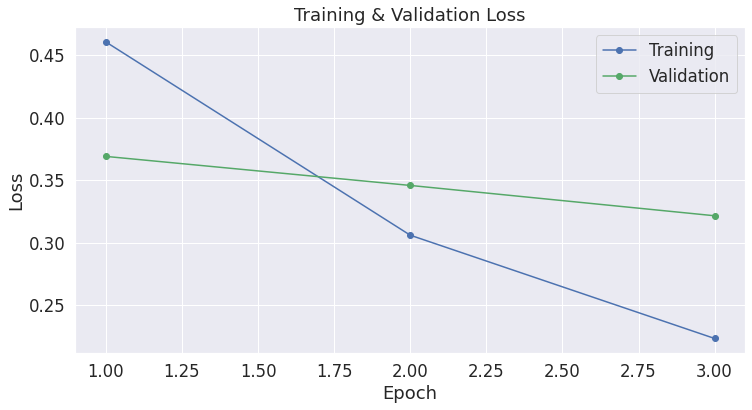

In [30]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
#plt.xticks([1, 2, 3, 4])

plt.show()

# Performance on Test set

Now we'll load the holdout dataset and prepare inputs just as we did with the training set. Then we'll evaluate predictions using [Matthew's correlation coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html) because this is the metric used by the wider NLP community to evaluate performance on CoLA. With this metric, +1 is the best score, and -1 is the worst score. This way, we can see how well we perform against the state of the art models for this specific task.

In [31]:
# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(test_df.shape[0]))

# Create sentence and label lists
test_tweets = test_df.text.values
labels = results.sentiment.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in test_tweets:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
prediction_inputs = torch.cat(input_ids, dim=0)
prediction_masks = torch.cat(attention_masks, dim=0)
prediction_labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 20  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 1,630



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [32]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 1,630 test sentences...
    DONE.


In [33]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 1,630 test sentences...
    DONE.


In [34]:
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
results.sentiment = flat_predictions

In [35]:
results.to_csv('results.csv', index = False)
!cp results.csv "./drive/My Drive/GA/capstone"

In [36]:
test_df['sentiment'] = flat_predictions

# Exporting model

In [37]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './drive/My Drive/GA/capstone/BERT with cleaned tweets'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to ./drive/My Drive/GA/capstone/BERT with cleaned tweets


('./drive/My Drive/GA/capstone/BERT with cleaned tweets/tokenizer_config.json',
 './drive/My Drive/GA/capstone/BERT with cleaned tweets/special_tokens_map.json',
 './drive/My Drive/GA/capstone/BERT with cleaned tweets/vocab.txt',
 './drive/My Drive/GA/capstone/BERT with cleaned tweets/added_tokens.json')

In [38]:
!ls -l --block-size=K './drive/My Drive/GA/capstone/BERT with cleaned tweets'

total 427983K
-rw------- 1 root root      1K Feb 25 09:35 config.json
-rw------- 1 root root 427754K Feb 25 09:35 pytorch_model.bin
-rw------- 1 root root      1K Feb 25 09:35 special_tokens_map.json
-rw------- 1 root root      1K Feb 25 09:35 tokenizer_config.json
-rw------- 1 root root    227K Feb 25 09:35 vocab.txt


In [39]:
# Prediction on training set

print('Predicting labels for {:,} train sentences...'.format(len(train_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
train_predictions , train_true_labels = [], []

# Predict 
for batch in train_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  train_predictions.append(logits)
  train_true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 2,513 train sentences...
    DONE.


In [40]:
# Prediction on train-validation set

print('Predicting labels for {:,} train sentences...'.format(len(validation_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
val_predictions , val_true_labels = [], []

# Predict 
for batch in validation_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  val_predictions.append(logits)
  val_true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 629 train sentences...
    DONE.


In [41]:
train_flat_predictions = [item for sublist in train_predictions for item in sublist]
train_flat_predictions = np.argmax(train_flat_predictions, axis=1).flatten()

val_flat_predictions = [item for sublist in val_predictions for item in sublist]
val_flat_predictions = np.argmax(val_flat_predictions, axis=1).flatten()

In [42]:
def conf_unravel(true,pred):
  tn, fp, fn, tp = confusion_matrix(true, pred).ravel()
  print("True Negatives: %s" % tn)
  print("False Positives: %s" % fp)
  print("False Negatives: %s" % fn)
  print("True Positives: %s" % tp)

  accuracy_clean = (tp + tn) / (tp + tn + fp + fn)
  print(f'Accuracy: {round(accuracy_clean,4)}')

  misclass_clean = (fp + fn) / (tp + tn + fp + fn)
  print(f'Misclassification Rate: {round(misclass_clean,4)}')

  spec_clean = tn / (tn + fp) #how many of the negatives was correctly classified
  print(f'Specificity: {round(spec_clean,4)}')

  sens_clean = tp / (tp + fn) #how many of the negatives was correctly identified
  print(f'Sensitivity: {round(sens_clean,4)}')

In [43]:
conf_unravel(validation_labels,val_flat_predictions)

True Negatives: 358
False Positives: 44
False Negatives: 37
True Positives: 190
Accuracy: 0.8712
Misclassification Rate: 0.1288
Specificity: 0.8905
Sensitivity: 0.837


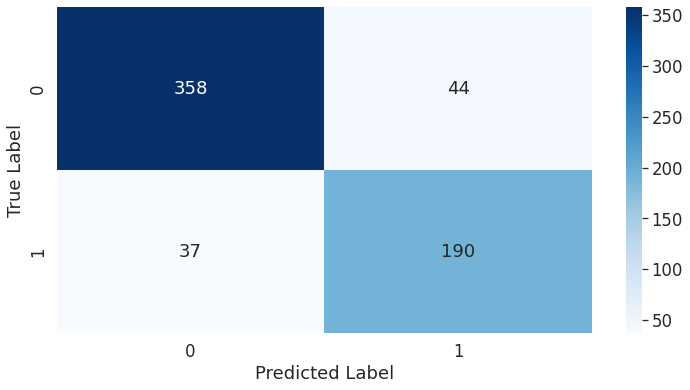

In [44]:
import seaborn as sns
sns.heatmap(confusion_matrix(validation_labels,val_flat_predictions),annot=True,fmt='g',cmap=plt.cm.Blues);
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix_bert.png')